In [34]:
import numpy as np
import pandas as pd
import geopandas as gpd

from matplotlib import cm
import matplotlib.pyplot as plt
from models import estimate_knn_clusters, estimate_som_clusters, prepare_whole_year, prepare_TS
from utils.utils import generate_filename
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from IPython.display import clear_output
from tslearn.barycenters import dtw_barycenter_averaging

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.svm import SVC


import plotly.express as px

from plotly.colors import qualitative
from matplotlib.colors import ListedColormap

import shap
import xgboost
from sklearn.preprocessing import LabelEncoder
shap.initjs()

px.set_mapbox_access_token("pk.eyJ1IjoiamdhY29zdGFzIiwiYSI6ImNsYWJwd3g1ZDAwaGUzb3Q0ZG04NDNndGgifQ.brk6kVA6biVSH0ovZ1dreA")

In [35]:
time_cols = ['60 or more minutes',
'45 to 59 minutes',
'35 to 44 minutes',
'30 to 34 minutes',
'25 to 29 minutes',
'20 to 24 minutes',
'15 to 19 minutes',
'10 to 14 minutes',
'Less than 10 minutes'
]

mode_cols = ['Car, truck, or van',
'Other',
'Public transportation',
'Walked',
]

time_mode_cols = ['Car, truck, or van Less than 10 minutes',
'Car, truck, or van 10 to 14 minutes',
'Car, truck, or van 15 to 19 minutes',
'Car, truck, or van 20 to 24 minutes',
'Car, truck, or van 25 to 29 minutes',
'Car, truck, or van 30 to 34 minutes',
'Car, truck, or van 35 to 44 minutes',
'Car, truck, or van 45 to 59 minutes',
'Car, truck, or van 60 or more minutes',
'Public transportation 10 to 14 minutes',
'Public transportation 15 to 19 minutes',
'Public transportation 20 to 24 minutes',
'Public transportation 25 to 29 minutes',
'Public transportation 30 to 34 minutes',
'Public transportation 35 to 44 minutes',
'Public transportation 45 to 59 minutes',
'Public transportation 60 or more minutes',
'Public transportation Bus 10 to 14 minutes',
'Walked Less than 10 minutes',
'Walked 10 to 14 minutes',
'Walked 15 to 19 minutes',
'Walked 20 to 24 minutes',
'Walked 25 to 29 minutes',
'Walked 30 to 34 minutes',
'Walked 35 to 44 minutes',
'Walked 45 to 59 minutes',
'Walked 60 or more minutes',
'Other Less than 10 minutes',
'Other 10 to 14 minutes',
'Other 15 to 19 minutes',
'Other 20 to 24 minutes',
'Other 25 to 29 minutes',
'Other 30 to 34 minutes',
'Other 35 to 44 minutes',
'Other 45 to 59 minutes',
'Other 60 or more minutes',
]

In [70]:
df_comtime = pd.read_csv('data/census/commute_times_mode/commute_times_zc_il.csv')

cols_comtimes = list(df_comtime.columns)[2:]
cols_comtimes_perc = []

#for col in cols_comtimes:
for col in time_mode_cols:
    new_col = f'{col}_perc'
    df_comtime[new_col] = df_comtime[col] / df_comtime['Total']
    cols_comtimes_perc.append(new_col)
    
print('Percentage check...')

if int(df_comtime[cols_comtimes_perc].sum(axis=1).sum()) == df_comtime.shape[0]:
    print('Successfully obtained percentages')
else:
    raise ValueError('Percentages do not add up to 1')

#df_clusters = estimate_knn_clusters(year=2019, month=7, day=10, n_clusters=5, metric='euclidean', df=True)
df_clusters = estimate_som_clusters(year=2019, month=1,  day=30, som_x=2, som_y=3, sigma=1, learning_rate = 0.5, df=True)
df_clusters['zip'] = df_clusters['GEOID20'].astype(int)

df_data = pd.merge(df_clusters[['zip', 'Cluster']], df_comtime[['zip', 'Total']+cols_comtimes_perc], on='zip').dropna()
df_data['Cluster_n'] = df_data['Cluster'].str[-1]#.astype(int)

Percentage check...
Successfully obtained percentages


In [71]:
X = df_data[cols_comtimes_perc]
y = df_data['Cluster_n']

cols_numeric = []
count_i = 0
for col in X.columns:
    df_data[f'{count_i}'] = df_data[col]
    cols_numeric.append(f'{count_i}') 
    count_i += 1

In [72]:

le = LabelEncoder()


In [98]:
X = df_data[cols_numeric]
y = df_data['Cluster_n']

X = df_data[cols_comtimes_perc]
y = df_data['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234, stratify=y)
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [99]:
bst = xgboost.XGBClassifier(n_estimators=60, max_depth=7, learning_rate=0.1, objective='multi:softmaxc')

In [100]:
bst.fit(X_train, y_train)
bst.score(X_train, y_train)

1.0

In [101]:
bst.score(X_test, y_test)

0.676056338028169

In [102]:
explainer = shap.Explainer(bst, X_train)
shap_values = explainer.shap_values(X_train)

 99%|===================| 1964/1980 [00:23<00:00]        

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

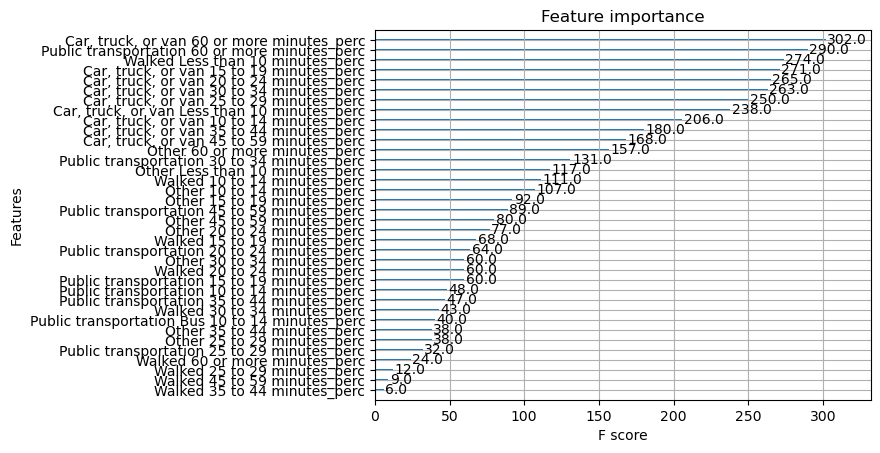

In [103]:
xgboost.plot_importance(bst)

In [104]:
plotly_cm = ListedColormap(['#EF553B', '#19D3F3', '#FFA15A', '#AB63FA', '#00CC96', '#636EFA'], name='my_colormap_name')

In [128]:
show_cols = []
for col in X_train.columns:
    a = col.replace('_perc', ' %')
    a = a.replace(' to ', '-')
    a = a.replace('minutes ', 'min')
    a = a.replace('Public transportation', 'PT:')
    a = a.replace('Car, truck, or van', 'Car:')
    a = a.replace('Walked', 'Walk:')
    a = a.replace('Other', 'Other:')
    a = a.replace('Less than 10', '<10')
    a = a.replace('60 or more', '60<')
    show_cols.append(a)

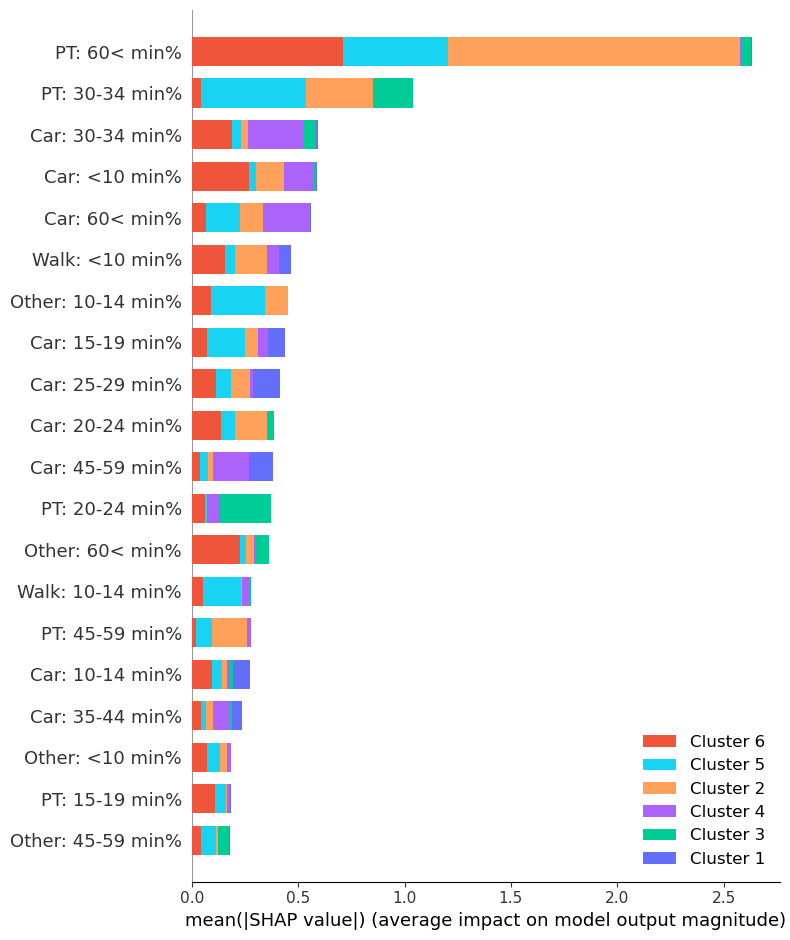

In [130]:
shap.summary_plot(shap_values, X_train, class_names=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'], color=plotly_cm, feature_names=show_cols)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


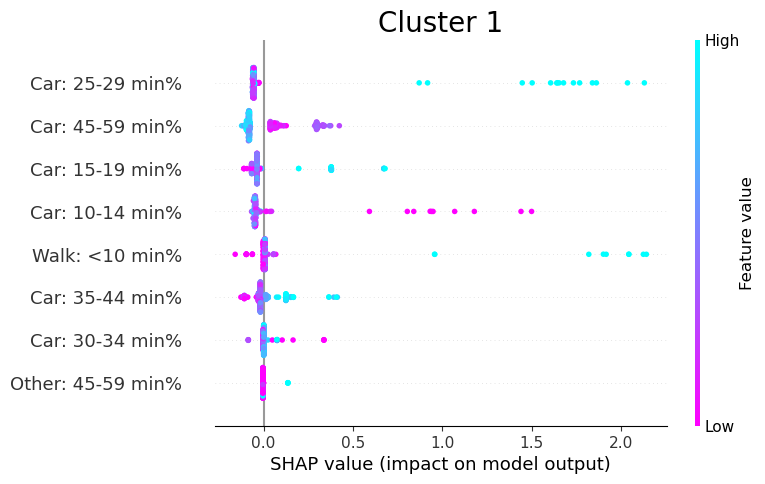

In [131]:
top_n = 8

shap.summary_plot(shap_values[0], X_train.values, feature_names = show_cols, cmap=plt.get_cmap("cool_r"), show=False, max_display=top_n)
plt.title('Cluster 1', fontsize=20)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


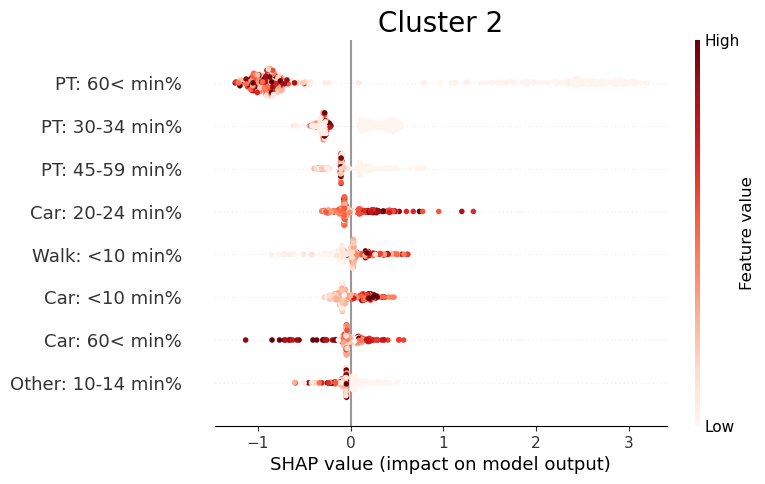

In [132]:
shap.summary_plot(shap_values[1], X_train.values, feature_names = show_cols, cmap=plt.get_cmap("Reds"), show=False, max_display=top_n)
plt.title('Cluster 2', fontsize=20)
plt.show()

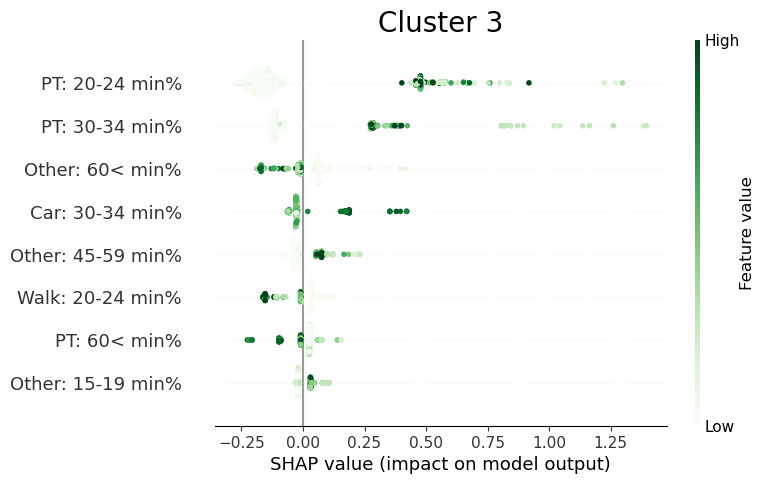

In [133]:
shap.summary_plot(shap_values[2], X_train.values, feature_names = show_cols, cmap=plt.get_cmap("Greens"), show=False, max_display=top_n)
plt.title('Cluster 3', fontsize=20)
plt.show()

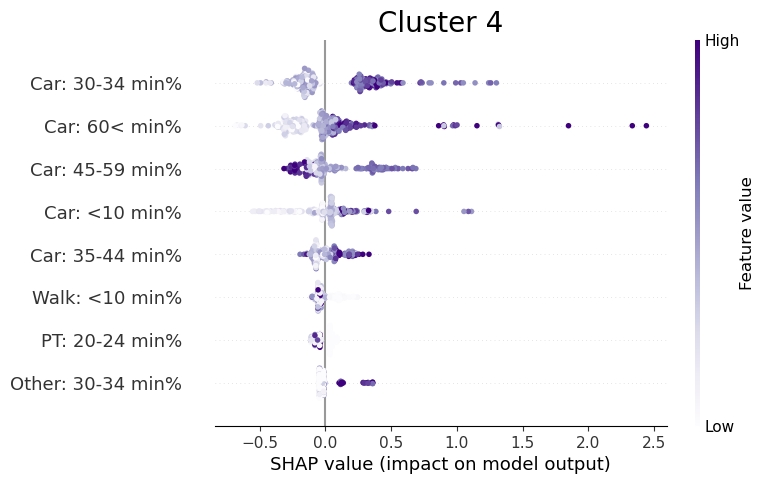

In [134]:
shap.summary_plot(shap_values[3], X_train.values, feature_names = show_cols, cmap=plt.get_cmap("Purples"), show=False, max_display=top_n)
plt.title('Cluster 4', fontsize=20)
plt.show()

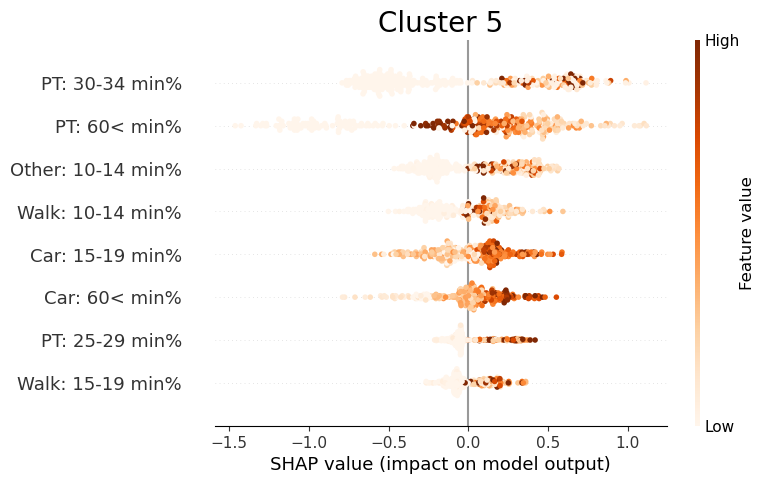

In [135]:
shap.summary_plot(shap_values[4], X_train.values, feature_names = show_cols, cmap=plt.get_cmap("Oranges"), show=False, max_display=top_n)
plt.title('Cluster 5', fontsize=20)
plt.show()

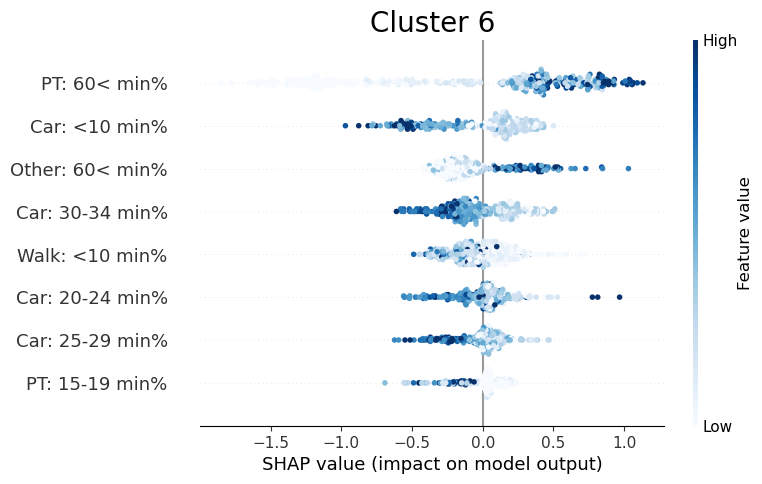

In [136]:
shap.summary_plot(shap_values[5], X_train.values, feature_names = show_cols, cmap=plt.get_cmap("Blues"), show=False, max_display=top_n)
plt.title('Cluster 6', fontsize=20)
plt.show()